In [4]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

from IPython.utils import io

In [2]:
print(sys.executable)

/usr/itetnas04/data-scratch-01/kvulic/data/conda_envs/spikesort/bin/python


In [2]:
SORTER_PATH = "/itet-stor/kvulic/neuronies/biohybrid_cmos/spike_sorting/Sorters/"
ANALYZER_PATH = "/itet-stor/kvulic/neuronies/biohybrid_cmos/spike_sorting/Analyzers/"
RECORDING_PATH = "/itet-stor/kvulic/neuronies/biohybrid_cmos/spike_sorting/Recordings/"

In [5]:
import spikeinterface.full as si
from pathlib import Path
import matplotlib.pyplot as plt
import os
import numpy as np
import json
job_kwargs = dict(n_jobs=6, chunk_duration='1s', progress_bar=True)
freq_min=200
freq_max=None

In [4]:
#list all files in the RECORDING_PATH that end with .h5
recording_files = [f for f in os.listdir(RECORDING_PATH) if f.endswith('.h5')]
recording_files = sorted(recording_files)
recording_files

['ID1649_N0_DIV14_DATE20240116_1530_spontaneous_.raw.h5',
 'ID1649_N0_DIV15_DATE20240116_1405_spontaneous_.raw.h5']

In [5]:
recording = si.read_maxwell(file_path=os.path.join(RECORDING_PATH, recording_files[1]))
recording = si.bandpass_filter(recording=recording,
                                                              freq_min=freq_min,
                                                              dtype='float32'
                                                              )
recording = si.common_reference(recording)
print(recording_files[1])
print(recording)

ID1649_N0_DIV15_DATE20240116_1405_spontaneous_.raw.h5
CommonReferenceRecording: 706 channels - 20.0kHz - 1 segments - 6,001,800 samples 
                          300.09s (5.00 minutes) - float32 dtype - 15.79 GiB


In [6]:
base_folder = ('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
sorters = os.listdir((SORTER_PATH))
sorters = sorted(sorters)
sorters

['Sorter_ID1649_N0_DIV14_DATE20240116_1530_spontaneous_.raw.h5',
 'Sorter_ID1649_N0_DIV15_DATE20240116_1405_spontaneous_.raw.h5',
 'Sorter_ID1649_N0_DIV23_DATE20240116_1352_spontaneous_.raw.h5']

In [7]:
sorting = si.read_sorter_folder(output_folder = os.path.join(SORTER_PATH,sorters[1]), register_recording=True, sorting_info=True, raise_error=True)
type(sorting)

spikeinterface.core.sortingfolder.NumpyFolderSorting

In [56]:
ANALYZER_PATH

'/itet-stor/kvulic/neuronies/single_neurons/4_Varia/Poster_data/Analyzers/'

In [63]:
analyzer = si.create_sorting_analyzer(sorting, recording, format='memory', sparse=True, **job_kwargs)

estimate_sparsity:   0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)

In [8]:
analyzer.compute("waveforms", ms_before=2.0, ms_after=2.0)
analyzer.compute("templates", operators=["average", "std"])
analyzer.compute("noise_levels")
analyzer.compute("template_similarity")
analyzer.compute("correlograms")
analyzer.compute("spike_amplitudes", **job_kwargs)
analyzer.compute("principal_components", n_components=3, mode="by_channel_global")

NameError: name 'analyzer' is not defined

In [ ]:
analyzer.save_as(folder = os.path.join(ANALYZER_PATH,recording_files[0][:-3]), format = "binary_folder")

In [9]:
analyzer = si.load_sorting_analyzer(os.path.join(ANALYZER_PATH,recording_files[0][:-3]))
analyzer_clean = si.load_sorting_analyzer(os.path.join(ANALYZER_PATH, recording_files[0][:-3]+"_clean"))

In [10]:
metric_names = si.get_quality_metric_list()
metrics = si.compute_quality_metrics(analyzer, metric_names=metric_names, **job_kwargs)

In [11]:
good_units_ids = metrics.query('snr > 5 & rp_contamination < 0.5').index.tolist()
len(good_units_ids)

249

In [60]:
#analyzer_clean = analyzer.select_units(good_units_ids)
si.remove_redundant_units(analyzer_clean)

UnitsSelectionSorting: 244 units - 1 segments - 20.0kHz

Exception: unit_ids is not a valid plot argument or backend keyword argument. Possible backend keyword arguments for matplotlib are: ['figure', 'ax', 'axes', 'ncols', 'figsize', 'figtitle']

In [ ]:
analyzer_clean.save_as(folder = os.path.join(ANALYZER_PATH, recording_files[0][:-3]+"_clean"), format="binary_folder")

In [39]:
amplitudes_by_units = {}
amplitudes = analyzer_clean.get_extension("spike_amplitudes").get_data()
spikes = analyzer_clean.sorting.to_spike_vector()
unit_ids = analyzer_clean.unit_ids

for unit_id in unit_ids:
    unit_index = analyzer_clean.sorting.id_to_index(unit_id)
    spike_mask =  spikes["unit_index"] == unit_index
    amplitudes_by_units[unit_id] = amplitudes[spike_mask]


filtered_good_units  = [unit for unit,amplitude_list in amplitudes_by_units.items() if len(amplitude_list) > 50]
good_units_ids = filtered_good_units
net_8_ids = [161,622,633,650,653,634]
good_units_ids = net_8_ids

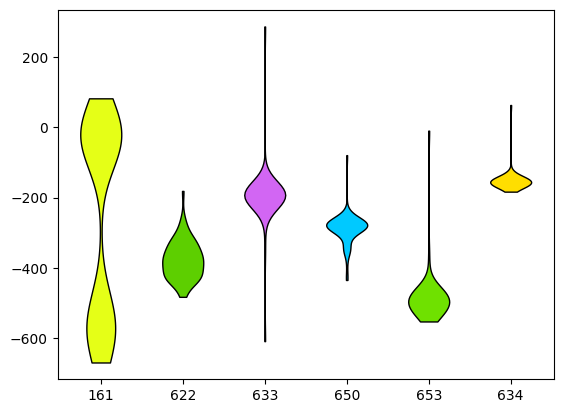

In [40]:
si.plot_all_amplitudes_distributions(analyzer_clean, unit_ids=good_units_ids)

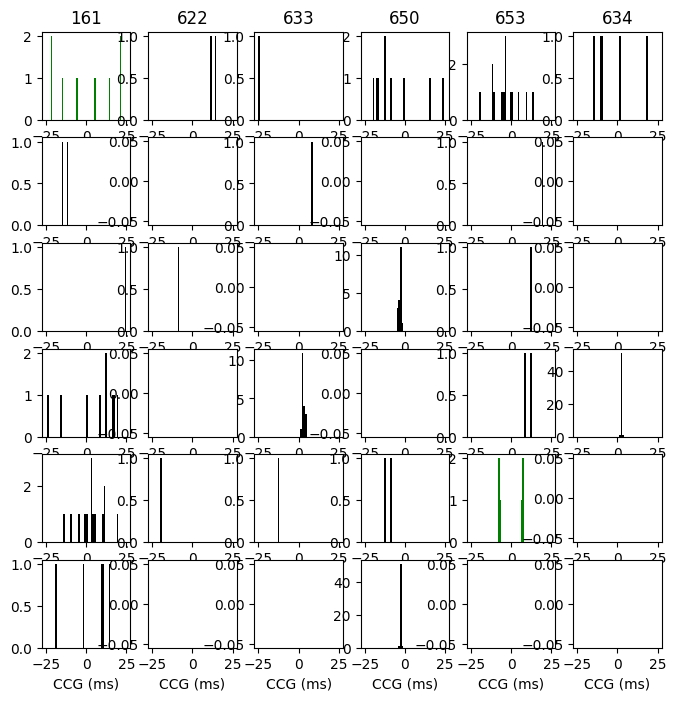

In [41]:
si.plot_crosscorrelograms(analyzer_clean, unit_ids=good_units_ids,window_ms = 10, figsize=(8, 8))

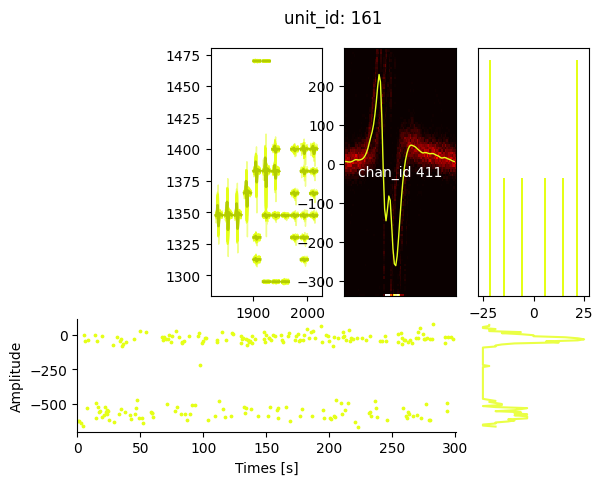

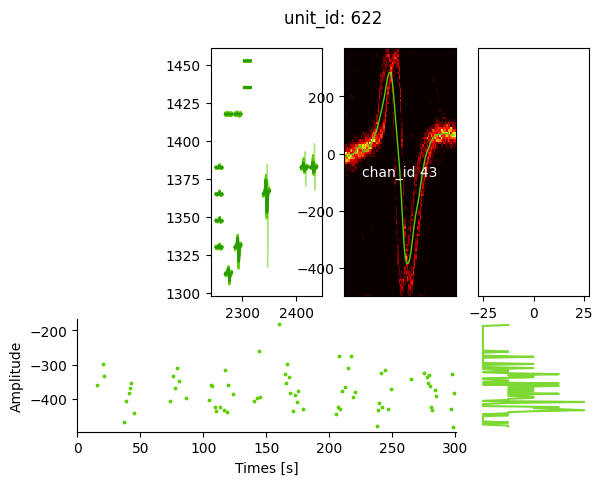

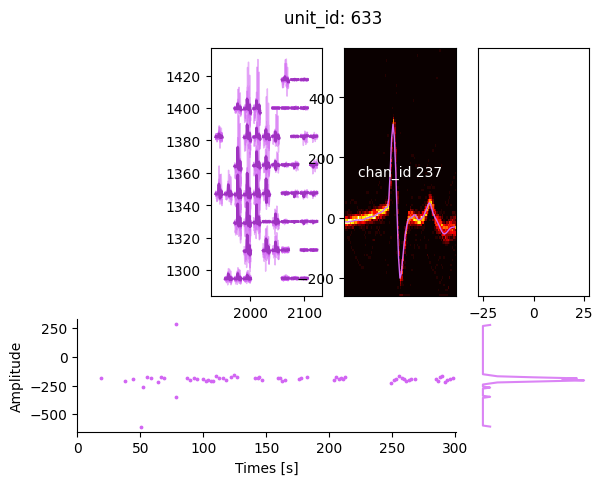

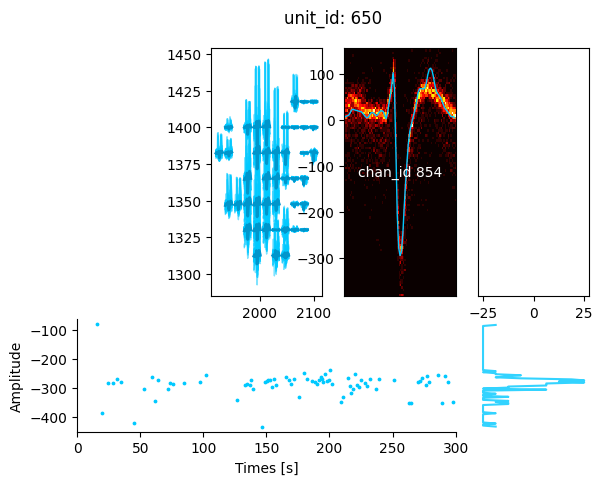

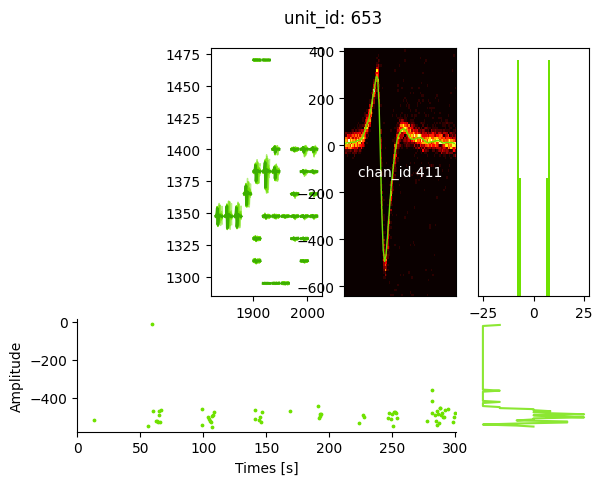

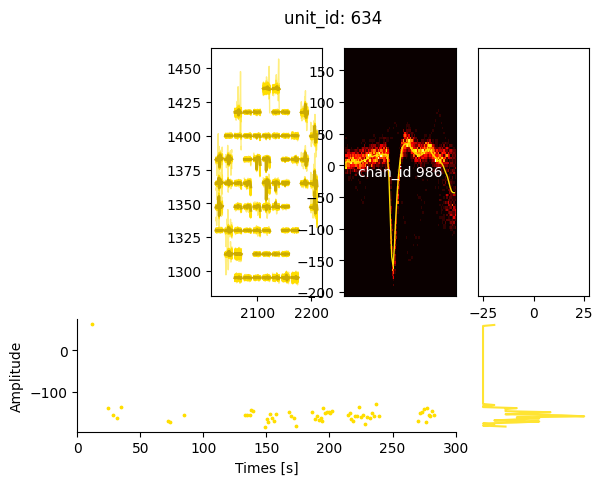

In [42]:
for unit in good_units_ids:
    si.plot_unit_summary(analyzer_clean, unit_id = unit)

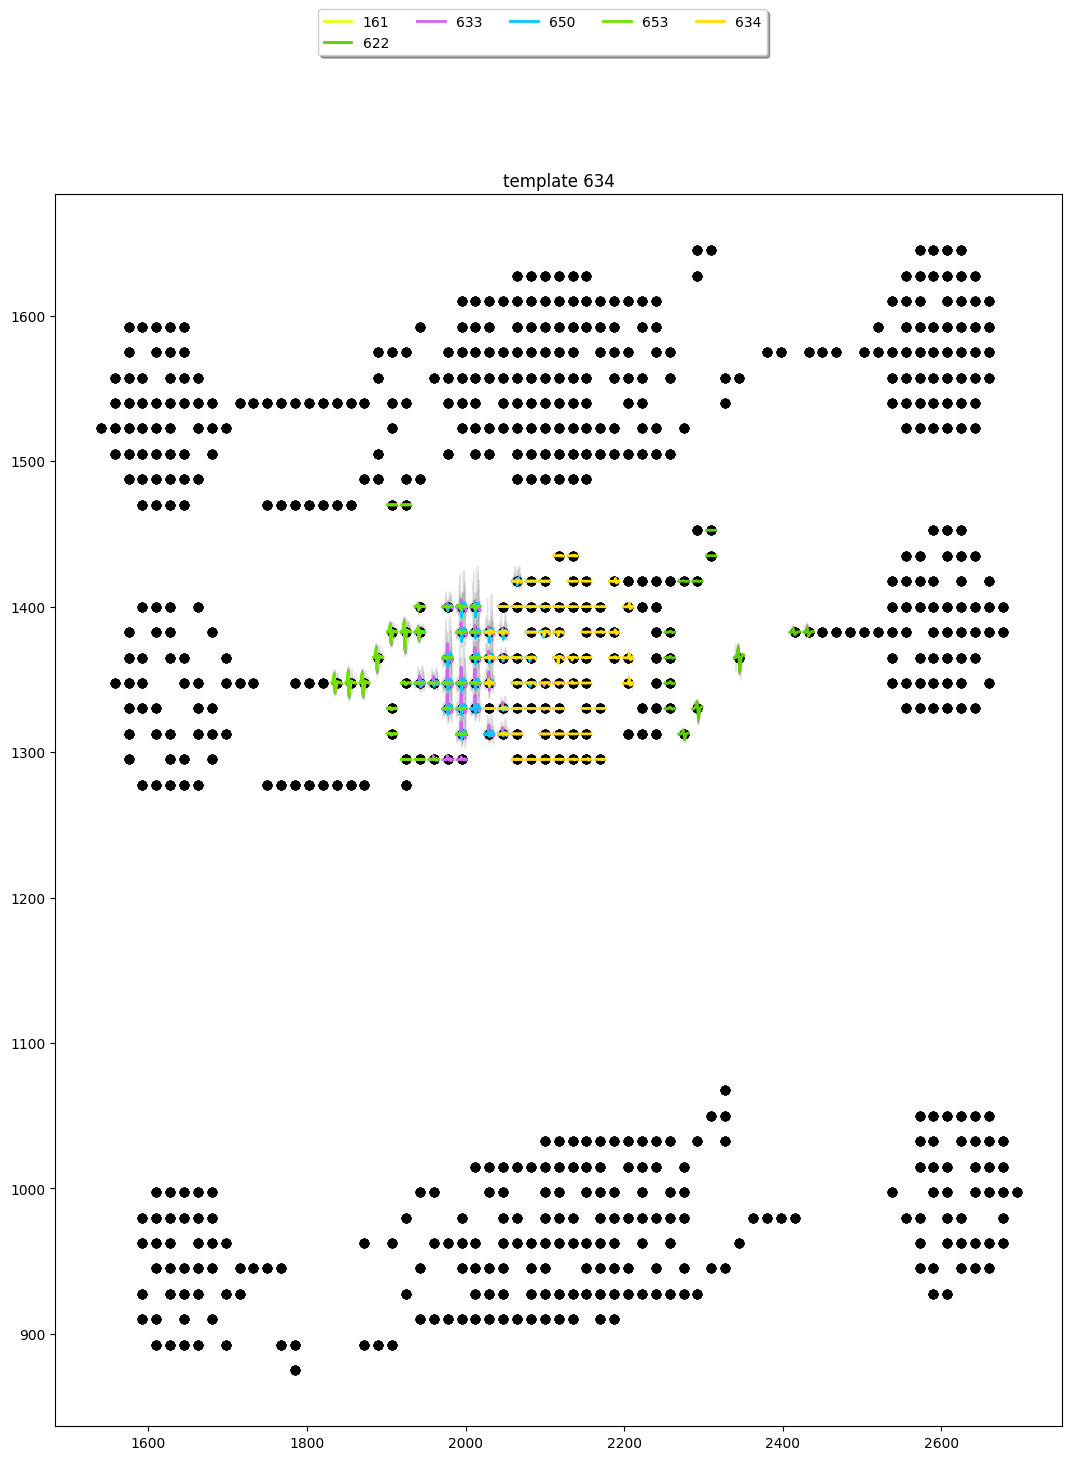

In [43]:
figure = si.plot_unit_templates(analyzer_clean, ncols=5, figsize=(13, 16), same_axis=True,
                                        plot_channels=True, unit_ids=[161,622,633,650,653,634])

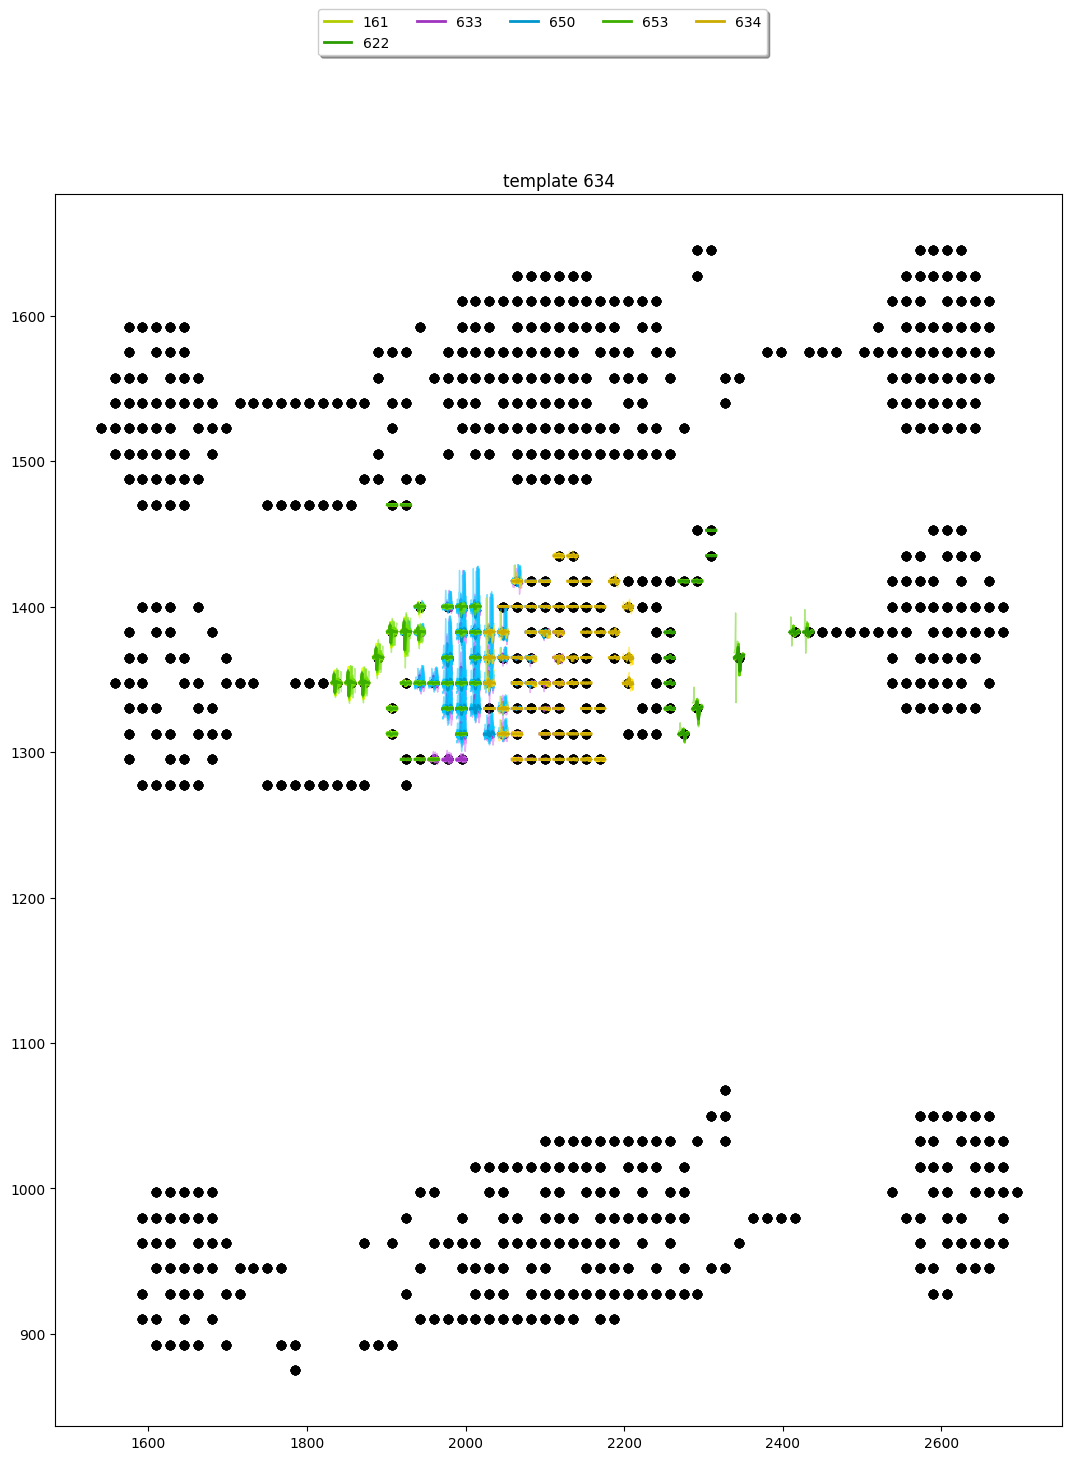

In [44]:
figure2 = si.plot_unit_waveforms(analyzer_clean, ncols=5, figsize=(13, 16), same_axis=True,
                                         plot_channels=True, unit_ids=good_units_ids)

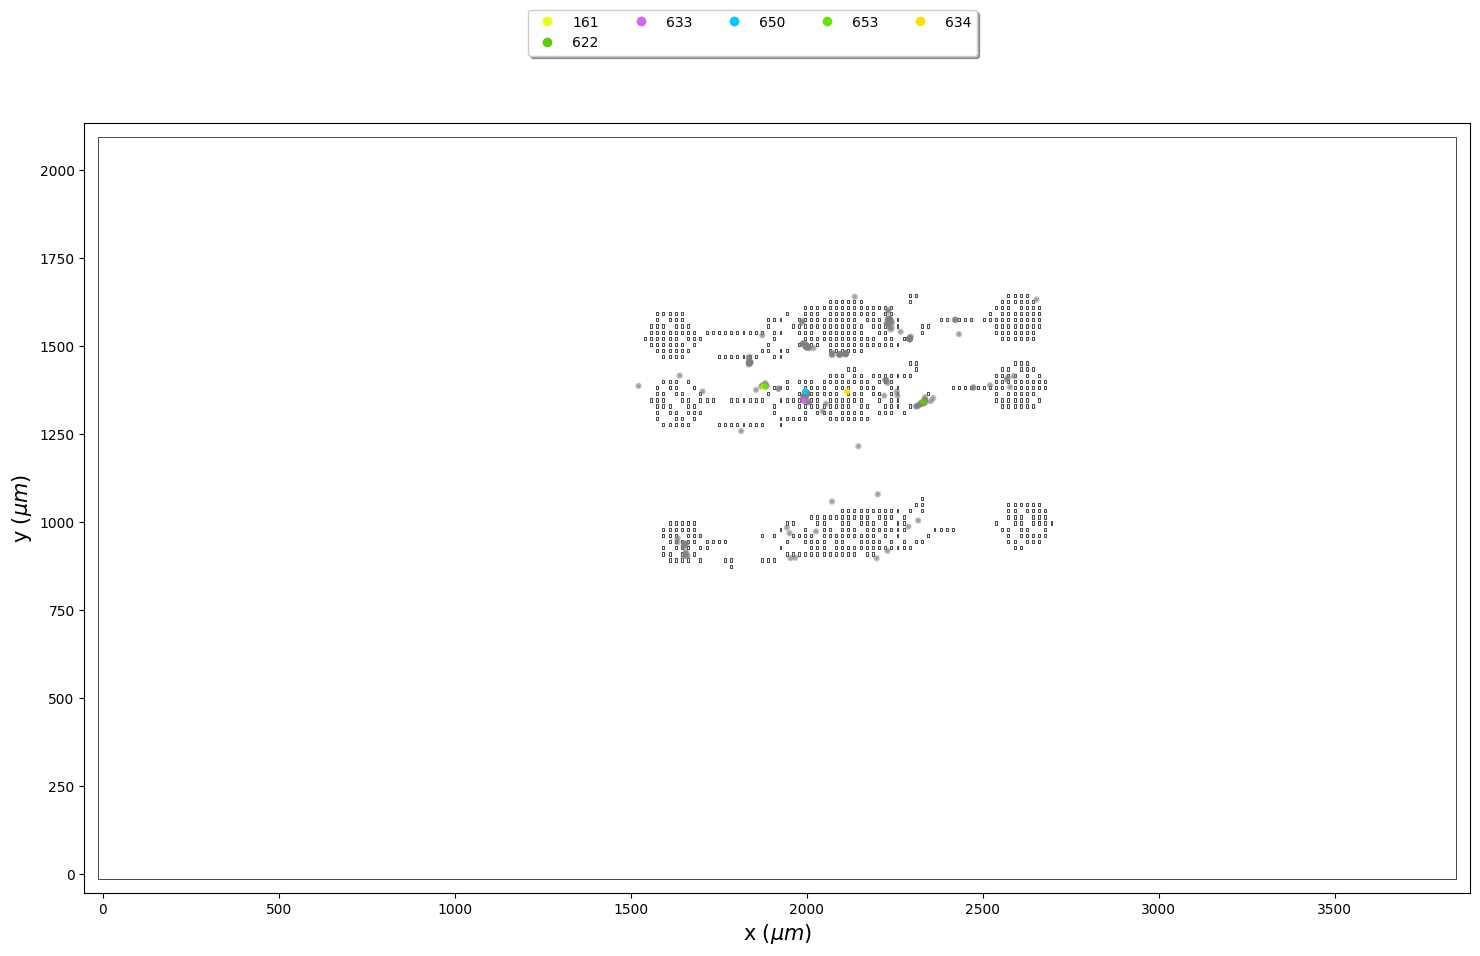

In [51]:
analyzer_clean.compute('unit_locations')
figure2 = si.plot_unit_locations(analyzer_clean, figsize=(20, 10), plot_legend=True,
                                        unit_ids=good_units_ids)

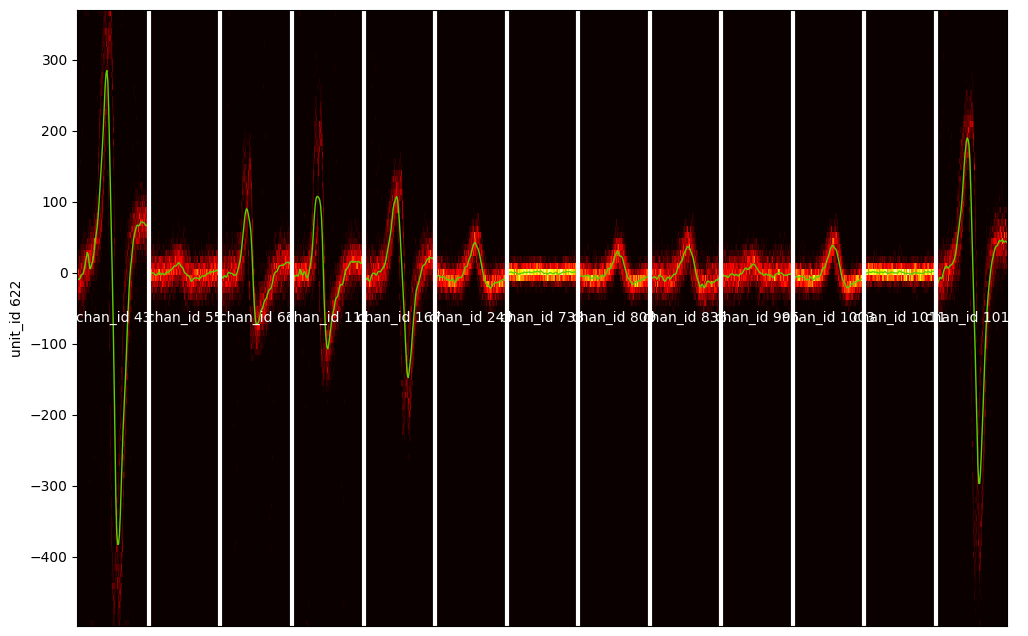

In [58]:
si.plot_unit_waveforms_density_map(analyzer_clean, unit_ids=[good_units_ids[1]], figsize=(12, 8))

In [ ]:

figure = si.widgets.plot_unit_templates(analyzer, ncols=5, figsize=(8, 16), same_axis=True,
                                        plot_channels=True, unit_ids=self.good_unit_ids)
plt.savefig(os.path.join(self.sorting_output_path, 'wf_folder_curated/templates.svg'))

figure1 = si.widgets.plot_unit_templates(self.waveform_extractor, ncols=10, figsize=(15, 20), same_axis=False,
                                        plot_channels=True, unit_ids=self.good_unit_ids)
plt.savefig(os.path.join(self.sorting_output_path, 'wf_folder_curated/templates_single.svg'))

#figure1 = si.widgets.plot_unit_waveforms(self.waveform_extractor, ncols=5, figsize=(8, 16), same_axis=True,
#                                         plot_channels=True, unit_ids=self.good_unit_ids)
#plt.savefig(os.path.join(self.sorting_output_path, 'wf_folder_curated/waveforms.svg'))

figure2 = si.widgets.plot_unit_locations(self.waveform_extractor, figsize=(20, 10), plot_legend=True,
                                        unit_ids=self.good_unit_ids)
plt.savefig(os.path.join(self.sorting_output_path, 'wf_folder_curated/locations.svg'))